In [1]:
import pandas as pd
import numpy as np
import os
import seaborn as sns
from math import radians

import matplotlib.pyplot as plt


import prep_plays

Acquire.py Loaded Successfully
Prep.py Loaded Successfully


Can we figure out the distance between the nearest defender and the intended reciever?
- Steps to go about solving this problem
    - merging play.csv to week{number}.csv
        - play id is only unique to game id, can concat both numbers to create a unique number
    - using play description to find the intended receiver
        - will be the second name in the list of names
        - given as first initial and last name
    - extract the name
    - match the name given the play id
        - the week{number}.csv gives both first and last name
    - out of all players involved in the play, who is the closest defender

# Creating a function for Plays and Weeks CSV

## Function for combining week(number).csv and plays data

In [2]:
#this function filters out the data to where the only observation
#will be the 'pass_forward' event
prep_plays.filter_nfl_weeks()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [2]:
#this function creates the shortest distance from the receiver 
#along with additional information
df = prep_plays.combine_all_weeks_and_plays()

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [3]:
df.to_csv('final.csv')

In [9]:
df = pd.read_csv('final.csv', index_col = [0])

## Initial exploration into "nulls"

The original dataframe had a little over 17,000 rows so we lost roughly 200 data points

Some receivers are unlabeled and have created "null values"

In [25]:
df

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,...,four_three,three_four,nickel,dime,playid,closest_dist,closest_x,closest_y,defender_receiver,week
0,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,3,7.0,4.0,0.0,15:00:00,90.0,...,0,0,1,0,201809060075,4.160048,76.53,44.93,Jalen Mills,1
1,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,3,7.0,4.0,0.0,13:10:00,49.0,...,0,0,1,0,2018090600146,4.243230,46.18,41.10,Malcolm Jenkins,1
2,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,3,6.0,4.0,0.0,13:05:00,49.0,...,0,0,1,0,2018090600168,5.338352,46.59,12.67,Sidney Jones,1
3,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,3,6.0,5.0,1.0,13:01:00,49.0,...,0,0,0,1,2018090600190,4.243218,39.77,22.27,Malcolm Jenkins,1
4,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,3,8.0,6.0,0.0,10:59:00,11.0,...,0,0,0,0,2018090600256,2.124382,8.20,33.31,Nate Gerry,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,(2:19) (Shotgun) P.Rivers pass short right to ...,4,2,2,19,6.0,4.0,0.0,02:19:00,77.0,...,0,0,1,0,20181222013842,4.763297,70.56,36.45,Brandon Carr,16
16821,(2:00) (Shotgun) P.Rivers pass short left to K...,4,1,10,19,4.0,5.0,0.0,02:00:00,70.0,...,0,0,0,1,20181222013884,2.076174,56.12,11.13,Jimmy Smith,16
16822,(1:41) (Shotgun) P.Rivers pass incomplete shor...,4,1,10,19,5.0,5.0,0.0,01:41:00,53.0,...,0,0,0,1,20181222013909,0.000000,0.00,0.00,unknown,16
16823,(1:37) (Shotgun) P.Rivers pass incomplete deep...,4,2,10,19,4.0,4.0,0.0,01:37:00,53.0,...,0,0,0,1,20181222013931,2.741678,42.50,12.68,Brandon Carr,16


In [26]:
df.closest_dist.value_counts()

0.000000      811
100.000000      7
2.015564        3
1.212642        3
1.144945        3
             ... 
2.344781        1
0.598415        1
4.673382        1
1.894466        1
1.811353        1
Name: closest_dist, Length: 15760, dtype: int64

In [50]:
df[df.closest_dist == 100]

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,...,four_three,three_four,nickel,dime,playid,closest_dist,closest_x,closest_y,defender_receiver,week
2067,(5:30) (Shotgun) T.Taylor pass short right to ...,2,3,12,11,5.0,4.0,0.0,05:30:00,71.0,...,0,0,0,1,20180920001539,100.0,0.0,0.0,Jamal Adams,3
2480,(5:43) (Shotgun) P.Mahomes pass incomplete dee...,2,1,10,4,7.0,5.0,0.0,05:43:00,49.0,...,0,0,1,0,20180923051553,100.0,0.0,0.0,Kendall Fuller,3
3074,(2:21) (Shotgun) R.Fitzpatrick pass deep left ...,2,1,10,1,5.0,4.0,0.0,02:21:00,54.0,...,0,0,1,0,20180924001867,100.0,0.0,0.0,Artie Burns,3
6222,(3:27) T.Brady pass short right to J.Develin t...,2,1,1,9,8.0,6.0,1.0,03:27:00,109.0,...,0,0,0,0,20181014121559,100.0,0.0,0.0,Josh Shaw,6
8593,(10:42) (Shotgun) K.Cousins pass deep right in...,2,1,10,14,6.0,4.0,0.0,10:42:00,59.0,...,0,0,1,0,20181104051062,100.0,0.0,0.0,Darius Slay,9
11229,(5:37) (Shotgun) L.Jackson pass short middle i...,2,3,10,21,5.0,3.0,0.0,05:37:00,40.0,...,0,0,0,1,20181125001824,100.0,0.0,0.0,Tahir Whitehead,12
15161,(1:45) (Shotgun) M.Cassel pass short middle to...,4,1,10,20,4.0,4.0,0.0,01:45:00,80.0,...,0,0,1,0,20181223074434,100.0,0.0,0.0,Ben Gedeon,16


In [10]:
# a little over 800 "null values"
# we can leave them as is or fill them in with the mean/median
# this needs to be done after we train, validate and test split
df[df.closest_dist == 0].pass_stopped.value_counts()

1    541
0    270
Name: pass_stopped, dtype: int64

In [11]:
df.pass_stopped.value_counts()

0    10965
1     5860
Name: pass_stopped, dtype: int64

In [24]:
df.closest_dist.max()

100.0

In [12]:
df.closest_dist.mean()

4.105335629896512

In [13]:
df.closest_dist.median()

3.446055716322645

In [14]:
df[df.pass_stopped == 1].closest_dist.mean()

2.8057709586383397

In [16]:
df[df.pass_stopped == 1].closest_dist.median()

1.982851482083313

In [15]:
df[df.pass_stopped == 0].closest_dist.mean()

4.799859020099204

In [17]:
df[df.pass_stopped == 0].closest_dist.median()

4.253339864153818

## Statistical testing

In [19]:
from scipy import stats

In [57]:
import seaborn as sns

In [20]:
pass_stopped = df[df.pass_stopped == 1]
pass_completed = df[df.pass_stopped == 0]

t, p = stats.ttest_ind(pass_stopped.closest_dist, pass_completed.closest_dist)
p

1.2245540507524944e-261

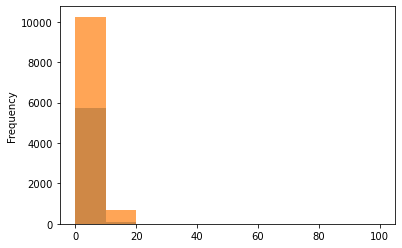

In [23]:
ax = df[df.pass_stopped == 1].closest_dist.plot.hist(label='time=one', alpha=.7)
df[df.pass_stopped == 0].closest_dist.plot.hist(label='time=two',ax=ax, alpha=.7)
ax.legend
plt.show()

In [63]:
df[df.closest_dist>50]

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,...,four_three,three_four,nickel,dime,playid,closest_dist,closest_x,closest_y,defender_receiver,week
2067,(5:30) (Shotgun) T.Taylor pass short right to ...,2,3,12,11,5.0,4.0,0.0,05:30:00,71.0,...,0,0,0,1,20180920001539,100.0,0.0,0.0,Jamal Adams,3
2480,(5:43) (Shotgun) P.Mahomes pass incomplete dee...,2,1,10,4,7.0,5.0,0.0,05:43:00,49.0,...,0,0,1,0,20180923051553,100.0,0.0,0.0,Kendall Fuller,3
3074,(2:21) (Shotgun) R.Fitzpatrick pass deep left ...,2,1,10,1,5.0,4.0,0.0,02:21:00,54.0,...,0,0,1,0,20180924001867,100.0,0.0,0.0,Artie Burns,3
6222,(3:27) T.Brady pass short right to J.Develin t...,2,1,1,9,8.0,6.0,1.0,03:27:00,109.0,...,0,0,0,0,20181014121559,100.0,0.0,0.0,Josh Shaw,6
8593,(10:42) (Shotgun) K.Cousins pass deep right in...,2,1,10,14,6.0,4.0,0.0,10:42:00,59.0,...,0,0,1,0,20181104051062,100.0,0.0,0.0,Darius Slay,9
11229,(5:37) (Shotgun) L.Jackson pass short middle i...,2,3,10,21,5.0,3.0,0.0,05:37:00,40.0,...,0,0,0,1,20181125001824,100.0,0.0,0.0,Tahir Whitehead,12
15161,(1:45) (Shotgun) M.Cassel pass short middle to...,4,1,10,20,4.0,4.0,0.0,01:45:00,80.0,...,0,0,1,0,20181223074434,100.0,0.0,0.0,Ben Gedeon,16


In [60]:
ex = df[df.closest_dist < 50]

sns.violinplot(ex.pass_stopped, ex.closest_dist)

## Functions for graphs % axis

In [21]:
def format_y_tick(tick_value, position):
    return '{:.0%}'.format(tick_value)

def format_x_tick(tick_value, postion):
    return '{:,}'.format(int(tick_value))

In [ ]:
#example on how to use the code


# fig, ax = plt.subplots(figsize = (9,5))

# ax.scatter(df.ml_coffee, df.p_days_absent)
# ax.set(
#     xlabel = 'coffee consumption(mL)',
#     ylabel = '% days absent',
#     title = 'coffee consumption does not correlate with absences'
# )
# ax.yaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_y_tick))
# ax.xaxis.set_major_formatter(mpl.ticker.FuncFormatter(format_x_tick))
# plt.show()

## checking null values from combine week_and_plays function

**From week 1, these plays have no information on them because of the following**
these plays have no intended receiver(15)
- 2018090600545	
- 20180906004366
- 20180906004417
- 20180909011330
- 20180909003607
- 20180909003702
- 20180909073055
- 20180909063808
- 2018090909249
- 2018090910477
- 20180909122115
- 20180909122519	
- 2018091000175
- 20180910012575	
- 20180910013099

these plays mislabeled the intended receiver
- 20180909033485
- 20180909034028
- 20180909034072
    - J.Smith(3)
    - this was changed to J.Smith-Schuster because he gets more reception and is less of a loss

- 20180909072787
- 20180909073716
    - J.O'Shaughnessy(2)
    - labeled as None

In [51]:
df

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,...,four_three,three_four,nickel,dime,playid,closest_dist,closest_x,closest_y,defender_receiver,week
0,(15:00) M.Ryan pass short right to J.Jones pus...,1,1,15,3,7.0,4.0,0.0,15:00:00,90.0,...,0,0,1,0,201809060075,4.160048,76.53,44.93,Jalen Mills,1
1,(13:10) M.Ryan pass incomplete short right to ...,1,1,10,3,7.0,4.0,0.0,13:10:00,49.0,...,0,0,1,0,2018090600146,4.243230,46.18,41.10,Malcolm Jenkins,1
2,(13:05) (Shotgun) M.Ryan pass incomplete short...,1,2,10,3,6.0,4.0,0.0,13:05:00,49.0,...,0,0,1,0,2018090600168,5.338352,46.59,12.67,Sidney Jones,1
3,(13:01) (Shotgun) M.Ryan pass deep left to J.J...,1,3,10,3,6.0,5.0,1.0,13:01:00,49.0,...,0,0,0,1,2018090600190,4.243218,39.77,22.27,Malcolm Jenkins,1
4,(10:59) (Shotgun) M.Ryan pass incomplete short...,1,3,1,3,8.0,6.0,0.0,10:59:00,11.0,...,0,0,0,0,2018090600256,2.124382,8.20,33.31,Nate Gerry,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
16820,(2:19) (Shotgun) P.Rivers pass short right to ...,4,2,2,19,6.0,4.0,0.0,02:19:00,77.0,...,0,0,1,0,20181222013842,4.763297,70.56,36.45,Brandon Carr,16
16821,(2:00) (Shotgun) P.Rivers pass short left to K...,4,1,10,19,4.0,5.0,0.0,02:00:00,70.0,...,0,0,0,1,20181222013884,2.076174,56.12,11.13,Jimmy Smith,16
16822,(1:41) (Shotgun) P.Rivers pass incomplete shor...,4,1,10,19,5.0,5.0,0.0,01:41:00,53.0,...,0,0,0,1,20181222013909,0.000000,0.00,0.00,unknown,16
16823,(1:37) (Shotgun) P.Rivers pass incomplete deep...,4,2,10,19,4.0,4.0,0.0,01:37:00,53.0,...,0,0,0,1,20181222013931,2.741678,42.50,12.68,Brandon Carr,16


In [53]:
###checking plays above
df[df.playid == 20181125001824]

,playDescription,quarter,down,yardsToGo,team_by_comp_yds,defendersInTheBox,numberOfPassRushers,QB_under_pressure,gameClock,absoluteYardlineNumber,...,four_three,three_four,nickel,dime,playid,closest_dist,closest_x,closest_y,defender_receiver,week
11229,(5:37) (Shotgun) L.Jackson pass short middle i...,2,3,10,21,5.0,3.0,0.0,05:37:00,40.0,...,0,0,0,1,20181125001824,100.0,0.0,0.0,Tahir Whitehead,12


In [54]:
###obtaining play description
#must insert correct quarterback
xyz.loc[xyz.displayName == "Lamar Jackson"].T

AttributeError: 'DataFrame' object has no attribute 'displayName'

In [55]:
###comparing names of last two rows shown
xyz.T

""
playDescription
quarter
down
yardsToGo
team_by_comp_yds
defendersInTheBox
numberOfPassRushers
QB_under_pressure
gameClock
absoluteYardlineNumber


# Football Field Demo

## Library and Function for Field

In [ ]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly

In [ ]:
def create_animation(week_number,play_id):
    df = pd.read_csv('week'+ str(week_number) +'.csv')
    dd=df[(df.playId==play_id)]
    times = dd.time.unique()
    time_slice = times[0:500:5]
    df = dd[dd.time.isin(time_slice)]
                     
    colorsIdx = {'home': 'red', 'away': 'blue', 'football': 'orange'}
    fig = px.scatter(df, x='x', y='y', color='team', text='jerseyNumber', animation_frame='time', 
                     color_discrete_map=colorsIdx,
                     range_x=[-10, 110],range_y=[-10, 53.3],
                     hover_data=['displayName', 'position', 's', 'a', 'dis', 'o', 'playDirection']
                    )
    fig.update_traces(marker_size=20)
    
    fig.update_layout(paper_bgcolor='#29a500', plot_bgcolor='#29a500', font_color='white',
        width = 800,
        height = 600,
        title = "",
        
        xaxis = dict(
        nticks = 10,
        title = "",
        visible=False
        ),
        
        yaxis = dict(
        scaleanchor = "x",
        title = "Temp",
        visible=False
        ),
        showlegend= True,
  
        annotations=[
       dict(
            x=-5,
            y=12,
            xref="x",
            yref="y",
            text="HOME ENDZONE",
            font=dict(size=16,color="#e9ece7"),
            align='center',
            showarrow=False,
            yanchor='bottom',
            textangle=-90
        ),
        dict(
            x=105,
            y=10,
            xref="x",
            yref="y",
            text="VISITOR ENDZONE",
            font=dict(size=16,color="#e9ece7"),
            align='center',
            showarrow=False,
            yanchor='bottom',
            textangle=90
        )]  
        ,
        legend=dict(
        traceorder="normal",
        font=dict(family="sans-serif",size=12),
        title = "",
        orientation="h",
        yanchor="bottom",
        y=1.00,
        xanchor="center",
        x=0.5
        ),
    )
    ####################################################
        
    fig.add_shape(type="rect", x0=-10, x1=0,  y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#217b00" ,layer="below")
    fig.add_shape(type="rect", x0=100, x1=110, y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#217b00" ,layer="below")
    for x in range(0, 100, 10):
        fig.add_shape(type="rect", x0=x,   x1=x+10, y0=0, y1=53.3,line=dict(color="#c8ddc0",width=3),fillcolor="#29a500" ,layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=1, x1=x, y1=2,line=dict(color="#c8ddc0",width=2),layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=51.3, x1=x, y1=52.3,line=dict(color="#c8ddc0",width=2),layer="below")
    
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=20.0, x1=x, y1=21,line=dict(color="#c8ddc0",width=2),layer="below")
    for x in range(0, 100, 1):
        fig.add_shape(type="line",x0=x, y0=32.3, x1=x, y1=33.3,line=dict(color="#c8ddc0",width=2),layer="below")
    
    
    fig.add_trace(go.Scatter(
    x=[2,10,20,30,40,50,60,70,80,90,98], y=[5,5,5,5,5,5,5,5,5,5,5],
    text=["G","1 0","2 0","3 0","4 0","5 0","4 0","3 0","2 0","1 0","G"],
    mode="text",
    textfont=dict(size=20,family="Arail"),
    showlegend=False,
    ))
    
    fig.add_trace(go.Scatter(
    x=[2,10,20,30,40,50,60,70,80,90,98], y=[48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3,48.3],
    text=["G","1 0","2 0","3 0","4 0","5 0","4 0","3 0","2 0","1 0","G"],
    mode="text",
    textfont=dict(size=20,family="Arail"),
    showlegend=False,
    ))
    
    return fig

## Function test

In [ ]:
week1 = pd.read_csv('week1.csv')

In [ ]:
[play for play in week1.playId.unique()]

## Animation

In [ ]:
create_animation(1,75)

In [ ]:
week1 = pd.read_csv('week1.csv')

In [ ]:
week1

In [ ]:
week1.event.value_counts()

In [ ]:
df = week1[week1.event != 'None']

In [ ]:
df

## Scratch Work Past This Point

# Prep week csv

## clean nfl weeks(drop noise)

In [ ]:
def filter_nfl_weeks():
    
    for i in range(1,18):
        #read in csv
        df = pd.read_csv('week' + str(i) + '.csv')
        #keep only pass_forward events
        df = df[(df.event == 'pass_forward')]
        #fill in empty positions with football
        df.position = df.position.fillna('BALL')
        #reset index
        df.reset_index(drop=True)
        #save as new csv
        df.to_csv('week' + str(i) + 'filtered.csv', index=False)
        #print week number when done
        print(f'{i}')

In [ ]:
filter_nfl_weeks()

## plays

In [ ]:
#read in csv
plays = prep_plays.prep_plays_for_weeks()

In [ ]:
plays.T

In [ ]:
#since playId is only unique to game id we need to combine to make a unique identifier
#first have to change the data types to strings
plays.gameId = plays.gameId.astype(str)
plays.playId = plays.playId.astype(str)

In [ ]:
#concat to create a unique identifier
plays['playid'] = plays.gameId + plays.playId

In [ ]:
#drop old columns
plays = plays.drop(columns = {'gameId', 'playId'})

In [ ]:
plays.drop_duplicates(inplace=True)

## week1

In [ ]:
#read in csv
wk1 = pd.read_csv('week10filtered.csv')

In [ ]:
wk1 = wk1.drop_duplicates()

In [ ]:
#since playId is only unique to game id we need to combine to make a unique identifier
#first have to change the data types to strings
wk1.gameId = wk1.gameId.astype(str)

wk1.playId = wk1.playId.astype(str)

In [ ]:
#concat to create a unique identifier
wk1['playid'] = wk1.gameId + wk1.playId

In [ ]:
wk1 = wk1.drop(columns = {'gameId', 'playId'})

In [ ]:
wk1.drop_duplicates(inplace=True)

## merge

In [ ]:
#merge 
df = pd.merge(plays, wk1, left_on = 'playid', right_on = 'playid', how = 'inner')

In [ ]:
df.drop_duplicates(inplace=True)

## Identify reciever

In [ ]:
import re

In [ ]:
#extracting names from play description
#second name will be the intended reciever
desc = df.playDescription.str.findall(r'(\b[A-Z]+\.\b[A-Z]+\w+)').apply(','.join)

In [ ]:
desc

In [ ]:
#split the desc namees by comma
temp = desc.str.split(',', expand = True)

In [ ]:
temp

In [ ]:
#checking reciever column for nulls
#there are some
#will have to write a loop that considers nulls and skips them
temp[1].isnull().value_counts()

In [ ]:
# obtaining name from WR column
temp[1]

In [ ]:
#saving name of receiver
df['receiver_last_name'] = temp[1]

In [ ]:
#checking dataframe
df

In [ ]:
#splitting first and last name of player
temp = df.displayName.str.split(' ', expand = True)

In [ ]:
temp

In [ ]:
initial = temp[0].astype(str).str[0]
initial

In [ ]:
last_name = temp[1]

In [ ]:
df['player_last_name'] = initial + '.' + last_name

In [ ]:
df = df[df.displayName != 'Football']

In [ ]:
#checking dataframe
df = df.reset_index(drop=True)

In [ ]:
df

In [ ]:
df.loc[(df.receiver_last_name == 'J.Smith'),'receiver_last_name']='J.Smith-Schuster'

In [ ]:
df.loc[(df.receiver_last_name == 'A.Seferian'),'receiver_last_name']='A.Seferian-Jenkins'

In [ ]:
df.loc[(df.receiver_last_name == 'R.Seals'),'receiver_last_name']='R.Seals-Jones'

In [ ]:
df.drop_duplicates(inplace=True)

## Distance

In [ ]:
# #passes where no receiver was identified
# df = df[~df.receiver_last_name.isnull()]

In [ ]:
# #no receiver was identified
# df = df[df.playid != '20180906004417']

In [ ]:
df

In [ ]:
newdf = pd.DataFrame(columns = ['playids', 'closest_dist', 'closest_x', 'closest_y', 'defender_receiver', 'week'])
playids = [
 
 
 
 
 
 
 
 
 '20181111062650',
 
]

#loop through each playid in playids
for play in playids:
    #reset shortest distance
    closest_distance = 100
    #reset shortest x
    closest_x = 0
    #reset shortest y
    closest_y = 0
    #filter for all players in current play
    current_play = df[df.playid == play]
    #create a dataframe of offensive players
    offense = current_play[(current_play.position == 'QB') | (current_play.position == 'RB') | (current_play.position == 'WR') | (current_play.position == 'FB') | (current_play.position == 'HB') | (current_play.position == 'TE')]
    #create a dataframe of defensive players
    defense = current_play[(current_play.position == 'CB') | (current_play.position == 'OLB') | (current_play.position == 'FS') | (current_play.position == 'SS') | (current_play.position == 'ILB') | (current_play.position == 'MLB') | (current_play.position == 'LB') | (current_play.position == 'DB') | (current_play.position == 'S') | (current_play.position == 'DL') | (current_play.position == 'DE') | (current_play.position == 'NT')]
    #for x in coordinates of players
    for name in defense.displayName:
        if (offense.receiver_last_name == offense.player_last_name).any():
            #retrieve y coordinate of this player
            x = defense.loc[defense.displayName == name].x.item()
            #retrieve y coordinate of this player
            y = defense.loc[defense.displayName == name].y.item()
            #retrive x coordinate of reciever
            x1= offense.loc[offense.receiver_last_name == offense.player_last_name].x.item()
            # retrieve y coordinate of reciever
            y1= offense.loc[offense.receiver_last_name == offense.player_last_name].y.item()
            #solve for distance
            distance = ((x-x1)**2+(y-y1)**2)**(1/2)
            #if the distance is the shortest distance
            if distance < closest_distance:
                #save the distance
                closest_distance = distance
                #save the x coordinate
                closest_x = x
                #save the y coordinate
                closest_y = y
                #save the defender name
                def_name = name
        else:
            #fill with unrealistic values 
            closest_distance = 0
            closest_x = 0
            closest_y = 0
            def_name = "unknown"
    newdf = newdf.append({'playids': play, 'closest_dist': closest_distance, 'closest_x': closest_x, 'closest_y': closest_y, 'defender_receiver': def_name, 'week':1}, ignore_index=True)

In [ ]:
newdf

In [ ]:
[play for play in df.playid.unique()]

# Best Defender 

In [4]:
df = prep_plays.get_weeksnplays_data()

Dataframe Ready For Use


In [15]:
# top 20 defenders directly involved in a pass play
df[df.defender_receiver != 'unknown'].defender_receiver.value_counts().head(20)

Eli Apple            101
Kyle Fuller          101
Kendall Fuller        99
James Bradberry       99
Jalen Ramsey          98
Adoree' Jackson       97
Prince Amukamara      94
Darius Leonard        93
Joe Haden             92
Kenny Moore           91
P.J. Williams         91
Captain Munnerlyn     90
T.J. Carrie           89
Steven Nelson         88
Stephon Gilmore       87
Byron Jones           87
Budda Baker           86
Justin Coleman        86
Chidobe Awuzie        86
Denzel Ward           85
Name: defender_receiver, dtype: int64

In [16]:
temp = df[df.pass_stopped == 1]

In [20]:
#top 20 defenders who were directly involved in stopping the pass play
temp[temp.defender_receiver != 'unknown'].defender_receiver.value_counts().head(20)

James Bradberry      49
Kyle Fuller          47
Jalen Ramsey         45
Eli Apple            45
Steven Nelson        44
Stephon Gilmore      44
Marlon Humphrey      42
Denzel Ward          42
Adoree' Jackson      41
Joe Haden            38
Orlando Scandrick    37
William Jackson      36
Brandon Carr         36
Jason McCourty       35
Morris Claiborne     35
Prince Amukamara     35
Darius Slay          35
Johnathan Joseph     34
Chidobe Awuzie       34
T.J. Carrie          34
Name: defender_receiver, dtype: int64

# EPA

## Statistical testing

In [2]:
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
alpha = .05

In [5]:
from sklearn.model_selection import train_test_split

train_validate, test = train_test_split(df, test_size=.3, random_state=123, stratify = df.pass_stopped)

train, validate = train_test_split(train_validate, test_size=.4, random_state=123, stratify = train_validate.pass_stopped)

In [6]:
pass_completed = train[train.pass_stopped == 0]
pass_not_completed = train[train.pass_stopped == 1]

t, p = stats.ttest_ind(pass_completed.epa, pass_not_completed.epa)
p

0.0

In [7]:
pass_completed.epa.mean()

0.7375291728811614

In [8]:
pass_completed.epa.min()

-9.67818757738637

In [9]:
pass_completed.epa.max()

8.62931613779587

In [10]:
pass_not_completed.epa.mean()

-1.0960165900885386

In [11]:
pass_not_completed.epa.min()

-11.372109718538999

In [12]:
pass_not_completed.epa.max()

2.3785095053919503

/usr/local/anaconda3/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


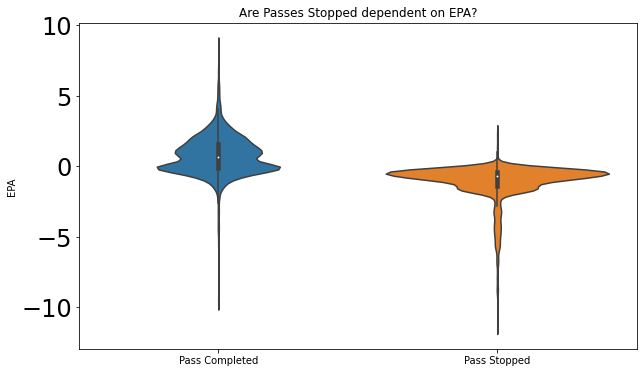

In [13]:
plt.rc("figure", figsize=(10, 6))
sns.violinplot(train.pass_stopped, train.epa)
plt.xlabel('')
plt.xticks([0,1], ['Pass Completed', 'Pass Stopped'])
plt.yticks(size = 24)
plt.ylabel('EPA')
plt.title("Are Passes Stopped dependent on EPA?")
plt.show()

In [15]:
train.T

,1945,11035,3867,10518,8749,10814,15058,3701,12302,1385,...,3794,14038,5249,15872,10672,7509,3671,5235,12280,10422
playDescription,(1:55) (Shotgun) E.Manning pass short left to ...,(2:00) (Shotgun) C.Newton pass short right to ...,(1:55) D.Carr pass short left to A.Cooper to O...,(2:50) (Shotgun) P.Rivers pass incomplete shor...,(13:37) (Shotgun) C.Keenum pass incomplete sho...,(6:36) (Shotgun) C.Daniel pass short right to ...,(7:51) (Shotgun) T.Brady pass short middle int...,(10:22) (Shotgun) C.Wentz pass short right to ...,(10:23) (Shotgun) D.Watson pass short right to...,(1:06) (Shotgun) B.Roethlisberger pass short l...,...,(13:43) (Shotgun) R.Tannehill pass short left ...,(2:44) J.Allen pass incomplete short right. Th...,(12:00) D.Watson pass short right to W.Fuller ...,(12:23) (Shotgun) B.Bortles pass incomplete sh...,"(14:00) (No Huddle, Shotgun) J.Goff pass short...",(:47) (Shotgun) B.Mayfield pass incomplete dee...,(:38) (Shotgun) M.Mariota pass short right to ...,(10:21) (Shotgun) D.Watson pass short left to ...,"(:30) (No Huddle, Shotgun) A.Rodgers pass inco...",(3:56) (Shotgun) D.Watson pass incomplete shor...
quarter,2,2,1,2,3,3,2,3,2,2,...,4,2,4,1,1,4,1,3,4,4
down,2,2,2,1,3,1,2,3,2,1,...,1,2,1,3,2,1,3,3,1,2
yardsToGo,10,1,10,4,2,10,7,6,10,10,...,10,7,10,9,4,10,11,19,10,7
team_by_comp_yds,10,15,16,19,23,22,9,8,12,2,...,28,31,12,25,5,11,29,12,7,12
defendersInTheBox,6,7,8,6,5,6,6,7,7,6,...,6,6,7,6,6,6,6,5,6,7
numberOfPassRushers,5,4,6,4,4,4,4,5,3,4,...,3,5,4,5,4,4,3,4,5,5
QB_under_pressure,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,0
gameClock,01:55:00,02:00:00,01:55:00,02:50:00,13:37:00,06:36:00,07:51:00,10:22:00,10:23:00,01:06:00,...,13:43:00,02:44:00,12:00:00,12:23:00,14:00:00,00:47:00,00:38:00,10:21:00,00:30:00,03:56:00
absoluteYardlineNumber,72,52,85,14,43,64,85,89,63,37,...,35,54,58,49,66,38,50,84,61,65


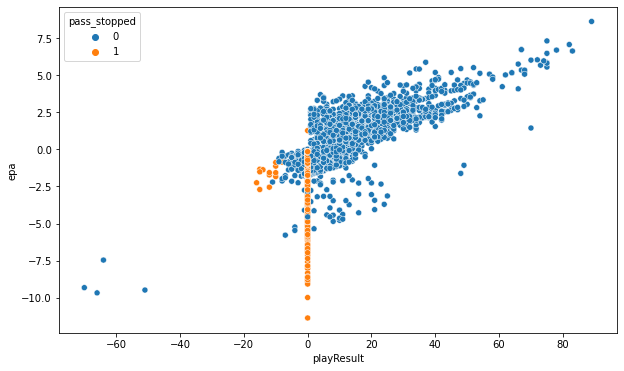

In [19]:
plt.title("")
sns.scatterplot(x="playResult", y="epa", data=train, hue="pass_stopped")
plt.show()

# End